# Flux Caching Tutorial: Accelerating Elastic Models with cache-dit

This tutorial demonstrates how to apply **cache-dit** caching techniques to **Elastic Flux models** for faster inference.

## Overview

**Elastic Models** allow you to trade off quality for speed by using different model sizes (S, XL, original). 
**cache-dit** is a caching framework that reduces redundant computations during diffusion model inference.

By combining these two approaches, we can achieve significant speedups while maintaining quality.

### What we'll cover:
1. Loading Elastic Flux models in different modes (S, XL, original)
2. Applying DualCache (aggressive and conservative) caching strategies
3. Comparing inference times with and without caching
4. Evaluating image quality metrics
5. Visualizing results

### DualCache Strategies:

**DualCache Aggressive** - High speedup, more caching:
- `Fn=1, Bn=0` (minimal recomputation)
- `rdt=0.2` (high threshold for cache invalidation)
- `max_continuous_cached_steps=10` (long cache reuse)
- Best for: Static scenes, mid-diffusion steps

**DualCache Conservative** - Balanced speedup, safer caching:
- `Fn=4, Bn=0` (more recomputation layers)
- `rdt=0.05` (low threshold, more frequent cache refresh)
- `max_continuous_cached_steps=3` (shorter cache reuse)
- Best for: Dynamic scenes, correcting accumulated errors

## 1. Setup and Imports

**⚠️ IMPORTANT: Diffusers Version Compatibility**

This tutorial uses `cache-dit` which is designed for newer versions of `diffusers` (with Chroma, HiDream models support). However, `elastic_models` may require an older version of `diffusers`.

**Two solutions:**
1. **Use our compatibility patch** (recommended) - see below
2. **Manually edit cache-dit** - comment out imports in:
   - `/path/to/cache_dit/cache_factory/patch_functors/functor_chroma.py`
   - `/path/to/cache_dit/cache_factory/patch_functors/functor_hidream.py`

Our utils automatically patch missing classes, so cache-dit works with older diffusers.

In [1]:
import os
import sys
import torch
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Add current directory to path for importing utils
sys.path.insert(0, os.path.dirname(os.path.abspath('__file__')))

# Import only utility functions (visualization, saving, compatibility)
from flux_caching_tutorial_utils import (
    setup_diffusers_compatibility,
    set_seed,
    visualize_comparison,
    create_performance_charts,
    print_performance_summary,
    save_results,
)

# Setup compatibility patches BEFORE importing cache-dit
setup_diffusers_compatibility()

# Now import elastic models and cache-dit
from elastic_models.diffusers import DiffusionPipeline as ElasticDiffusionPipeline
import cache_dit
from cache_dit import BasicCacheConfig, BlockAdapter, ForwardPattern

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports complete")

Checking diffusers compatibility...
⚠ Patched missing classes: ChromaTransformer2DModel, HiDreamImageTransformer2DModel, QwenImageTransformer2DModel
⚠ Patched missing modules: transformer_chroma, transformer_hidream, transformer_hidream_image, transformer_qwenimage
✓ Compatibility patches applied successfully


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/util/files.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources impor

✓ All imports complete


## 2. Configuration

In [2]:
# Device and dtype
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.bfloat16

# Model configuration
MODEL_NAME = 'black-forest-labs/FLUX.1-dev'
HF_TOKEN = None  # Set your HuggingFace token here if needed
HF_CACHE_DIR = '/mount/huggingface_cache'  # Change to your cache directory
MODEL_PATH = None  # Path to elastic model weights (if custom)

# Generation parameters
WIDTH = 1024
HEIGHT = 1024
NUM_INFERENCE_STEPS = 28
GUIDANCE_SCALE = 3.5
SEED = 42

# Test prompts
TEST_PROMPTS = [
    "A majestic lion standing on a rocky cliff at sunset",
    "A futuristic city skyline with flying cars and neon lights",
    "A beautiful garden with blooming flowers and butterflies",
]

# Output directory
OUTPUT_DIR = Path('./flux_caching_tutorial_results')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Device: {device}")
print(f"Model: {MODEL_NAME}")
print(f"Image size: {WIDTH}x{HEIGHT}")
print(f"Inference steps: {NUM_INFERENCE_STEPS}")
print(f"Test prompts: {len(TEST_PROMPTS)}")

Device: cuda
Model: black-forest-labs/FLUX.1-dev
Image size: 1024x1024
Inference steps: 28
Test prompts: 3


## 3. Core Functions for Elastic Models and Cache-Dit

These are the key functions demonstrating how to use cache-dit with elastic_models.

In [3]:
def load_elastic_pipeline(mode='original', model_path=None):
    """
    Load Elastic Flux pipeline in specified mode.
    
    This shows how to load elastic models in different configurations:
    - 'original': Full model
    - 'XL': Larger elastic variant
    - 'S': Smaller elastic variant (faster)
    """
    print(f"\n{'='*60}")
    print(f"Loading Elastic Flux pipeline - Mode: {mode}")
    print(f"{'='*60}")
    
    if mode == 'original':
        pipeline = ElasticDiffusionPipeline.from_pretrained(
            MODEL_NAME,
            torch_dtype=dtype,
            cache_dir=HF_CACHE_DIR,
            token=HF_TOKEN,
            device_map=device,
        )
    else:
        # Load elastic model with specific mode
        pipeline = ElasticDiffusionPipeline.from_pretrained(
            MODEL_NAME,
            torch_dtype=dtype,
            cache_dir=HF_CACHE_DIR,
            token=HF_TOKEN,
            mode=mode,  # 'XL' or 'S'
            device_map=device,
            __model_path=model_path,
        )
    
    pipeline = pipeline.to(device)
    print(f"✓ Pipeline loaded successfully")
    return pipeline


def enable_dualcache(pipeline, mode='conservative'):
    """
    Enable DualCache on Flux pipeline.
    
    This demonstrates how to apply cache-dit to elastic models:
    
    - 'aggressive': More caching, higher speedup
      * Fn=1, rdt=0.2, max_continuous=10
    - 'conservative': Safer caching, balanced speedup
      * Fn=4, rdt=0.05, max_continuous=3
    """
    print(f"\nEnabling DualCache ({mode} mode)...")
    
    # Configure cache parameters based on mode
    if mode == 'aggressive':
        Fn = 1
        Bn = 0
        max_warmup_steps = 8
        max_continuous_cached_steps = 10
        residual_diff_threshold = 0.2
    else:  # conservative
        Fn = 4
        Bn = 0
        max_warmup_steps = 8
        max_continuous_cached_steps = 3
        residual_diff_threshold = 0.05
    
    # Create cache configuration
    cache_config = BasicCacheConfig(
        Fn_compute_blocks=Fn,
        Bn_compute_blocks=Bn,
        max_warmup_steps=max_warmup_steps,
        max_cached_steps=-1,
        max_continuous_cached_steps=max_continuous_cached_steps,
        residual_diff_threshold=residual_diff_threshold,
    )
    
    # Check if blocks are compiled (important for elastic models)
    first_block = pipeline.transformer.transformer_blocks[0]
    is_compiled = hasattr(first_block, '__wrapped__') or 'Compiled' in type(first_block).__name__
    
    # Enable cache using BlockAdapter for Flux architecture
    cache_dit.enable_cache(
        BlockAdapter(
            pipe=pipeline,
            transformer=pipeline.transformer,
            blocks=[
                pipeline.transformer.transformer_blocks,
                pipeline.transformer.single_transformer_blocks,
            ],
            forward_pattern=[
                ForwardPattern.Pattern_1,  # For transformer_blocks
                ForwardPattern.Pattern_3,  # For single_transformer_blocks
            ],
            check_forward_pattern=not is_compiled,
        ),
        cache_config=cache_config
    )
    
    print(f"✓ DualCache enabled: Fn={Fn}, rdt={residual_diff_threshold}, max_continuous={max_continuous_cached_steps}")


def disable_cache(pipeline):
    """Disable cache on pipeline."""
    cache_dit.disable_cache(pipeline)
    print("✓ Cache disabled")


def generate_and_time(pipeline, prompt, seed=42):
    """Generate image and measure time."""
    set_seed(seed)
    generator = torch.Generator(device=device).manual_seed(seed)
    
    torch.cuda.synchronize()
    start_time = time.time()
    
    result = pipeline(
        prompt=prompt,
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFERENCE_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        generator=generator,
    )
    
    torch.cuda.synchronize()
    elapsed = time.time() - start_time
    
    return result.images[0], elapsed


print("✓ Core functions defined")

✓ Core functions defined


## 4. Experiment: Mode XL

We'll compare:
1. XL mode without caching (baseline)
2. XL mode with DualCache Aggressive
3. XL mode with DualCache Conservative

In [4]:
results_xl = {}

print("\n" + "="*70)
print("EXPERIMENT: Mode XL")
print("="*70)

# Load XL pipeline
pipeline_xl = load_elastic_pipeline(mode='XL', model_path=MODEL_PATH)


EXPERIMENT: Mode XL

Loading Elastic Flux pipeline - Mode: XL


Loading elastic checkpoint: 100%|██████████| 57/57 [00:56<00:00,  1.00it/s]


✓ Pipeline loaded successfully


### 4.1 XL - No Caching (Baseline)

In [5]:
# Warmup
print("\nWarmup...")
_ = generate_and_time(pipeline_xl, TEST_PROMPTS[0], seed=SEED)
print("✓ Warmup complete")

# Generate test images without caching
print("\nGenerating images (no caching)...")
images_xl_nocache = []
times_xl_nocache = []

for i, prompt in enumerate(TEST_PROMPTS):
    print(f"\nPrompt {i+1}/{len(TEST_PROMPTS)}: {prompt}")
    image, elapsed = generate_and_time(pipeline_xl, prompt, seed=SEED+i)
    images_xl_nocache.append(image)
    times_xl_nocache.append(elapsed)
    print(f"Time: {elapsed:.2f}s")

avg_time_xl_nocache = np.mean(times_xl_nocache)
print(f"\nAverage time (XL no caching): {avg_time_xl_nocache:.2f}s")

results_xl['no_cache'] = {
    'images': images_xl_nocache,
    'times': times_xl_nocache,
    'avg_time': avg_time_xl_nocache
}


Warmup...


100%|██████████| 28/28 [00:03<00:00,  8.63it/s]


✓ Warmup complete

Generating images (no caching)...

Prompt 1/3: A majestic lion standing on a rocky cliff at sunset


100%|██████████| 28/28 [00:03<00:00,  8.70it/s]


Time: 4.16s

Prompt 2/3: A futuristic city skyline with flying cars and neon lights


100%|██████████| 28/28 [00:03<00:00,  8.70it/s]


Time: 4.17s

Prompt 3/3: A beautiful garden with blooming flowers and butterflies


100%|██████████| 28/28 [00:03<00:00,  8.70it/s]


Time: 4.17s

Average time (XL no caching): 4.17s


### 4.2 XL - DualCache Aggressive

In [6]:
# Enable aggressive caching
enable_dualcache(pipeline_xl, mode='aggressive')

# Warmup with cache
print("\nWarmup with cache...")
_ = generate_and_time(pipeline_xl, TEST_PROMPTS[0], seed=SEED)
print("✓ Warmup complete")

# Generate test images
print("\nGenerating images (DualCache Aggressive)...")
images_xl_aggressive = []
times_xl_aggressive = []

for i, prompt in enumerate(TEST_PROMPTS):
    print(f"\nPrompt {i+1}/{len(TEST_PROMPTS)}: {prompt}")
    image, elapsed = generate_and_time(pipeline_xl, prompt, seed=SEED+i)
    images_xl_aggressive.append(image)
    times_xl_aggressive.append(elapsed)
    print(f"Time: {elapsed:.2f}s")

avg_time_xl_aggressive = np.mean(times_xl_aggressive)
speedup_xl_aggressive = avg_time_xl_nocache / avg_time_xl_aggressive
print(f"\nAverage time (XL aggressive): {avg_time_xl_aggressive:.2f}s")
print(f"Speedup: {speedup_xl_aggressive:.2f}x")

cache_stats_xl_aggressive = cache_dit.summary(pipeline_xl)

results_xl['aggressive'] = {
    'images': images_xl_aggressive,
    'times': times_xl_aggressive,
    'avg_time': avg_time_xl_aggressive,
    'speedup': speedup_xl_aggressive,
    'cache_stats': cache_stats_xl_aggressive
}

disable_cache(pipeline_xl)


Enabling DualCache (aggressive mode)...
INFO 11-24 21:13:29 [block_adapters.py:201] Auto fill blocks_name: ['transformer_blocks', 'single_transformer_blocks'].
WARNING 11-24 21:13:29 [block_adapters.py:124] _diffusers_hook is not None, force skip pattern check!
INFO 11-24 21:13:29 [cache_adapter.py:76] Adapting Cache Acceleration using custom BlockAdapter!
WARNING 11-24 21:13:29 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_1
WARNING 11-24 21:13:29 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_3
INFO 11-24 21:13:29 [cache_adapter.py:145] Use default 'enable_separate_cfg' from block adapter register: False, Pipeline: FluxPipeline.
INFO 11-24 21:13:29 [cache_adapter.py:319] Collected Context Config: DBCache_F1B0_W8I1M0MC10_R0.2, Calibrator Config: None
INFO 11-24 21:13:29 [cache_adapter.py:319] Collected Context Config: DBCache_F1B0_W8I1M0MC10_R0.2, Calibrator Config: None
WARNING 11-24 21:13:29 [pattern_base.py:67] Skipped

100%|██████████| 28/28 [00:01<00:00, 14.71it/s]


✓ Warmup complete

Generating images (DualCache Aggressive)...

Prompt 1/3: A majestic lion standing on a rocky cliff at sunset


100%|██████████| 28/28 [00:01<00:00, 14.69it/s]


Time: 2.14s

Prompt 2/3: A futuristic city skyline with flying cars and neon lights


100%|██████████| 28/28 [00:01<00:00, 14.84it/s]


Time: 2.12s

Prompt 3/3: A beautiful garden with blooming flowers and butterflies


100%|██████████| 28/28 [00:01<00:00, 14.82it/s]


Time: 2.12s

Average time (XL aggressive): 2.13s
Speedup: 1.96x

🤗Context Options: QlipCompiledModule

{'cache_config': BasicCacheConfig(cache_type=<CacheType.DBCache: 'DBCache'>, Fn_compute_blocks=1, Bn_compute_blocks=0, residual_diff_threshold=0.2, max_warmup_steps=8, warmup_interval=1, max_cached_steps=-1, max_continuous_cached_steps=10, enable_separate_cfg=False, cfg_compute_first=False, cfg_diff_compute_separate=True), 'name': 'single_transformer_blocks_140642471003904'}
WARNING 11-24 21:13:38 [utils.py:293] Can't find Parallelism Config for: QlipCompiledModule

⚡️Cache Steps and Residual Diffs Statistics: QlipCompiledModule

| Cache Steps | Diffs P00 | Diffs P25 | Diffs P50 | Diffs P75 | Diffs P95 | Diffs Min | Diffs Max |
|-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| 15          | 0.025     | 0.047     | 0.071     | 0.132     | 0.7       | 0.025     | 0.742     |


🤗Context Options: QlipCompiledModule

{'cache_config': Basi

### 4.3 XL - DualCache Conservative

In [7]:
# Enable conservative caching
enable_dualcache(pipeline_xl, mode='conservative')

# Warmup with cache
print("\nWarmup with cache...")
_ = generate_and_time(pipeline_xl, TEST_PROMPTS[0], seed=SEED)
print("✓ Warmup complete")

# Generate test images
print("\nGenerating images (DualCache Conservative)...")
images_xl_conservative = []
times_xl_conservative = []

for i, prompt in enumerate(TEST_PROMPTS):
    print(f"\nPrompt {i+1}/{len(TEST_PROMPTS)}: {prompt}")
    image, elapsed = generate_and_time(pipeline_xl, prompt, seed=SEED+i)
    images_xl_conservative.append(image)
    times_xl_conservative.append(elapsed)
    print(f"Time: {elapsed:.2f}s")

avg_time_xl_conservative = np.mean(times_xl_conservative)
speedup_xl_conservative = avg_time_xl_nocache / avg_time_xl_conservative
print(f"\nAverage time (XL conservative): {avg_time_xl_conservative:.2f}s")
print(f"Speedup: {speedup_xl_conservative:.2f}x")

cache_stats_xl_conservative = cache_dit.summary(pipeline_xl)

results_xl['conservative'] = {
    'images': images_xl_conservative,
    'times': times_xl_conservative,
    'avg_time': avg_time_xl_conservative,
    'speedup': speedup_xl_conservative,
    'cache_stats': cache_stats_xl_conservative
}

disable_cache(pipeline_xl)
del pipeline_xl
torch.cuda.empty_cache()
print("\n✓ XL experiments complete")


Enabling DualCache (conservative mode)...
INFO 11-24 21:13:38 [block_adapters.py:201] Auto fill blocks_name: ['transformer_blocks', 'single_transformer_blocks'].
WARNING 11-24 21:13:38 [block_adapters.py:124] _diffusers_hook is not None, force skip pattern check!
INFO 11-24 21:13:38 [cache_adapter.py:76] Adapting Cache Acceleration using custom BlockAdapter!
WARNING 11-24 21:13:38 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_1
WARNING 11-24 21:13:38 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_3
INFO 11-24 21:13:38 [cache_adapter.py:145] Use default 'enable_separate_cfg' from block adapter register: False, Pipeline: FluxPipeline.
INFO 11-24 21:13:38 [cache_adapter.py:319] Collected Context Config: DBCache_F4B0_W8I1M0MC3_R0.05, Calibrator Config: None
INFO 11-24 21:13:38 [cache_adapter.py:319] Collected Context Config: DBCache_F4B0_W8I1M0MC3_R0.05, Calibrator Config: None
WARNING 11-24 21:13:38 [pattern_base.py:67] Skipp

100%|██████████| 28/28 [00:03<00:00,  9.04it/s]


✓ Warmup complete

Generating images (DualCache Conservative)...

Prompt 1/3: A majestic lion standing on a rocky cliff at sunset


100%|██████████| 28/28 [00:03<00:00,  9.01it/s]


Time: 3.33s

Prompt 2/3: A futuristic city skyline with flying cars and neon lights


100%|██████████| 28/28 [00:03<00:00,  9.01it/s]


Time: 3.33s

Prompt 3/3: A beautiful garden with blooming flowers and butterflies


100%|██████████| 28/28 [00:03<00:00,  8.98it/s]


Time: 3.34s

Average time (XL conservative): 3.33s
Speedup: 1.25x

🤗Context Options: QlipCompiledModule

{'cache_config': BasicCacheConfig(cache_type=<CacheType.DBCache: 'DBCache'>, Fn_compute_blocks=4, Bn_compute_blocks=0, residual_diff_threshold=0.05, max_warmup_steps=8, warmup_interval=1, max_cached_steps=-1, max_continuous_cached_steps=3, enable_separate_cfg=False, cfg_compute_first=False, cfg_diff_compute_separate=True), 'name': 'single_transformer_blocks_140642471003904'}
WARNING 11-24 21:13:51 [utils.py:293] Can't find Parallelism Config for: QlipCompiledModule

⚡️Cache Steps and Residual Diffs Statistics: QlipCompiledModule

| Cache Steps | Diffs P00 | Diffs P25 | Diffs P50 | Diffs P75 | Diffs P95 | Diffs Min | Diffs Max |
|-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| 7           | 0.03      | 0.038     | 0.213     | 0.36      | 0.412     | 0.03      | 0.418     |


🤗Context Options: QlipCompiledModule

{'cache_config': Ba

## 5. Experiment: Mode S

We'll compare:
1. S mode without caching (baseline)
2. S mode with DualCache Aggressive
3. S mode with DualCache Conservative

In [8]:
results_s = {}

print("\n" + "="*70)
print("EXPERIMENT: Mode S")
print("="*70)

# Load S pipeline
pipeline_s = load_elastic_pipeline(mode='S', model_path=MODEL_PATH)


EXPERIMENT: Mode S

Loading Elastic Flux pipeline - Mode: S


Loading elastic checkpoint: 100%|██████████| 57/57 [00:25<00:00,  2.23it/s]


✓ Pipeline loaded successfully


### 5.1 S - No Caching (Baseline)

In [9]:
# Warmup
print("\nWarmup...")
_ = generate_and_time(pipeline_s, TEST_PROMPTS[0], seed=SEED)
print("✓ Warmup complete")

# Generate test images without caching
print("\nGenerating images (no caching)...")
images_s_nocache = []
times_s_nocache = []

for i, prompt in enumerate(TEST_PROMPTS):
    print(f"\nPrompt {i+1}/{len(TEST_PROMPTS)}: {prompt}")
    image, elapsed = generate_and_time(pipeline_s, prompt, seed=SEED+i)
    images_s_nocache.append(image)
    times_s_nocache.append(elapsed)
    print(f"Time: {elapsed:.2f}s")

avg_time_s_nocache = np.mean(times_s_nocache)
print(f"\nAverage time (S no caching): {avg_time_s_nocache:.2f}s")

results_s['no_cache'] = {
    'images': images_s_nocache,
    'times': times_s_nocache,
    'avg_time': avg_time_s_nocache
}


Warmup...


100%|██████████| 28/28 [00:02<00:00, 13.34it/s]


✓ Warmup complete

Generating images (no caching)...

Prompt 1/3: A majestic lion standing on a rocky cliff at sunset


100%|██████████| 28/28 [00:02<00:00, 13.25it/s]


Time: 2.70s

Prompt 2/3: A futuristic city skyline with flying cars and neon lights


100%|██████████| 28/28 [00:02<00:00, 13.26it/s]


Time: 2.71s

Prompt 3/3: A beautiful garden with blooming flowers and butterflies


100%|██████████| 28/28 [00:02<00:00, 13.20it/s]


Time: 2.72s

Average time (S no caching): 2.71s


### 5.2 S - DualCache Aggressive

In [10]:
# Enable aggressive caching
enable_dualcache(pipeline_s, mode='aggressive')

# Warmup with cache
print("\nWarmup with cache...")
_ = generate_and_time(pipeline_s, TEST_PROMPTS[0], seed=SEED)
print("✓ Warmup complete")

# Generate test images
print("\nGenerating images (DualCache Aggressive)...")
images_s_aggressive = []
times_s_aggressive = []

for i, prompt in enumerate(TEST_PROMPTS):
    print(f"\nPrompt {i+1}/{len(TEST_PROMPTS)}: {prompt}")
    image, elapsed = generate_and_time(pipeline_s, prompt, seed=SEED+i)
    images_s_aggressive.append(image)
    times_s_aggressive.append(elapsed)
    print(f"Time: {elapsed:.2f}s")

avg_time_s_aggressive = np.mean(times_s_aggressive)
speedup_s_aggressive = avg_time_s_nocache / avg_time_s_aggressive
print(f"\nAverage time (S aggressive): {avg_time_s_aggressive:.2f}s")
print(f"Speedup: {speedup_s_aggressive:.2f}x")

cache_stats_s_aggressive = cache_dit.summary(pipeline_s)

results_s['aggressive'] = {
    'images': images_s_aggressive,
    'times': times_s_aggressive,
    'avg_time': avg_time_s_aggressive,
    'speedup': speedup_s_aggressive,
    'cache_stats': cache_stats_s_aggressive
}

disable_cache(pipeline_s)


Enabling DualCache (aggressive mode)...
INFO 11-24 21:14:33 [block_adapters.py:201] Auto fill blocks_name: ['transformer_blocks', 'single_transformer_blocks'].
WARNING 11-24 21:14:33 [block_adapters.py:124] _diffusers_hook is not None, force skip pattern check!
INFO 11-24 21:14:33 [cache_adapter.py:76] Adapting Cache Acceleration using custom BlockAdapter!
WARNING 11-24 21:14:33 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_1
WARNING 11-24 21:14:33 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_3
INFO 11-24 21:14:33 [cache_adapter.py:145] Use default 'enable_separate_cfg' from block adapter register: False, Pipeline: FluxPipeline.
INFO 11-24 21:14:33 [cache_adapter.py:319] Collected Context Config: DBCache_F1B0_W8I1M0MC10_R0.2, Calibrator Config: None
INFO 11-24 21:14:33 [cache_adapter.py:319] Collected Context Config: DBCache_F1B0_W8I1M0MC10_R0.2, Calibrator Config: None
WARNING 11-24 21:14:33 [pattern_base.py:67] Skipped

100%|██████████| 28/28 [00:01<00:00, 21.25it/s]


✓ Warmup complete

Generating images (DualCache Aggressive)...

Prompt 1/3: A majestic lion standing on a rocky cliff at sunset


100%|██████████| 28/28 [00:01<00:00, 21.36it/s]


Time: 1.50s

Prompt 2/3: A futuristic city skyline with flying cars and neon lights


100%|██████████| 28/28 [00:01<00:00, 22.69it/s]


Time: 1.43s

Prompt 3/3: A beautiful garden with blooming flowers and butterflies


100%|██████████| 28/28 [00:01<00:00, 22.78it/s]


Time: 1.42s

Average time (S aggressive): 1.45s
Speedup: 1.87x

🤗Context Options: QlipCompiledModule

{'cache_config': BasicCacheConfig(cache_type=<CacheType.DBCache: 'DBCache'>, Fn_compute_blocks=1, Bn_compute_blocks=0, residual_diff_threshold=0.2, max_warmup_steps=8, warmup_interval=1, max_cached_steps=-1, max_continuous_cached_steps=10, enable_separate_cfg=False, cfg_compute_first=False, cfg_diff_compute_separate=True), 'name': 'single_transformer_blocks_140642380159520'}
WARNING 11-24 21:14:39 [utils.py:293] Can't find Parallelism Config for: QlipCompiledModule

⚡️Cache Steps and Residual Diffs Statistics: QlipCompiledModule

| Cache Steps | Diffs P00 | Diffs P25 | Diffs P50 | Diffs P75 | Diffs P95 | Diffs Min | Diffs Max |
|-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| 15          | 0.117     | 0.139     | 0.155     | 0.187     | 0.637     | 0.117     | 0.641     |


🤗Context Options: QlipCompiledModule

{'cache_config': Basic

### 5.3 S - DualCache Conservative

In [11]:
# Enable conservative caching
enable_dualcache(pipeline_s, mode='conservative')

# Warmup with cache
print("\nWarmup with cache...")
_ = generate_and_time(pipeline_s, TEST_PROMPTS[0], seed=SEED)
print("✓ Warmup complete")

# Generate test images
print("\nGenerating images (DualCache Conservative)...")
images_s_conservative = []
times_s_conservative = []

for i, prompt in enumerate(TEST_PROMPTS):
    print(f"\nPrompt {i+1}/{len(TEST_PROMPTS)}: {prompt}")
    image, elapsed = generate_and_time(pipeline_s, prompt, seed=SEED+i)
    images_s_conservative.append(image)
    times_s_conservative.append(elapsed)
    print(f"Time: {elapsed:.2f}s")

avg_time_s_conservative = np.mean(times_s_conservative)
speedup_s_conservative = avg_time_s_nocache / avg_time_s_conservative
print(f"\nAverage time (S conservative): {avg_time_s_conservative:.2f}s")
print(f"Speedup: {speedup_s_conservative:.2f}x")

cache_stats_s_conservative = cache_dit.summary(pipeline_s)

results_s['conservative'] = {
    'images': images_s_conservative,
    'times': times_s_conservative,
    'avg_time': avg_time_s_conservative,
    'speedup': speedup_s_conservative,
    'cache_stats': cache_stats_s_conservative
}

disable_cache(pipeline_s)
del pipeline_s
torch.cuda.empty_cache()
print("\n✓ S experiments complete")


Enabling DualCache (conservative mode)...
INFO 11-24 21:14:39 [block_adapters.py:201] Auto fill blocks_name: ['transformer_blocks', 'single_transformer_blocks'].
WARNING 11-24 21:14:39 [block_adapters.py:124] _diffusers_hook is not None, force skip pattern check!
INFO 11-24 21:14:39 [cache_adapter.py:76] Adapting Cache Acceleration using custom BlockAdapter!
WARNING 11-24 21:14:39 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_1
WARNING 11-24 21:14:39 [block_adapters.py:452] Skipped Forward Pattern Check: ForwardPattern.Pattern_3
INFO 11-24 21:14:39 [cache_adapter.py:145] Use default 'enable_separate_cfg' from block adapter register: False, Pipeline: FluxPipeline.
INFO 11-24 21:14:39 [cache_adapter.py:319] Collected Context Config: DBCache_F4B0_W8I1M0MC3_R0.05, Calibrator Config: None
INFO 11-24 21:14:39 [cache_adapter.py:319] Collected Context Config: DBCache_F4B0_W8I1M0MC3_R0.05, Calibrator Config: None
WARNING 11-24 21:14:39 [pattern_base.py:67] Skipp

100%|██████████| 28/28 [00:02<00:00, 11.73it/s]


✓ Warmup complete

Generating images (DualCache Conservative)...

Prompt 1/3: A majestic lion standing on a rocky cliff at sunset


100%|██████████| 28/28 [00:02<00:00, 11.77it/s]


Time: 2.57s

Prompt 2/3: A futuristic city skyline with flying cars and neon lights


100%|██████████| 28/28 [00:02<00:00, 11.45it/s]


Time: 2.63s

Prompt 3/3: A beautiful garden with blooming flowers and butterflies


100%|██████████| 28/28 [00:02<00:00, 11.72it/s]


Time: 2.58s

Average time (S conservative): 2.59s
Speedup: 1.05x

🤗Context Options: QlipCompiledModule

{'cache_config': BasicCacheConfig(cache_type=<CacheType.DBCache: 'DBCache'>, Fn_compute_blocks=4, Bn_compute_blocks=0, residual_diff_threshold=0.05, max_warmup_steps=8, warmup_interval=1, max_cached_steps=-1, max_continuous_cached_steps=3, enable_separate_cfg=False, cfg_compute_first=False, cfg_diff_compute_separate=True), 'name': 'single_transformer_blocks_140642380159520'}
WARNING 11-24 21:14:50 [utils.py:293] Can't find Parallelism Config for: QlipCompiledModule

⚡️Cache Steps and Residual Diffs Statistics: QlipCompiledModule

| Cache Steps | Diffs P00 | Diffs P25 | Diffs P50 | Diffs P75 | Diffs P95 | Diffs Min | Diffs Max |
|-------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| 0           | 0.16      | 0.175     | 0.313     | 0.408     | 0.494     | 0.16      | 0.52      |


🤗Context Options: QlipCompiledModule

{'cache_config': Bas

## 6. Performance Summary

In [12]:
# Print performance summary using utility function
print_performance_summary(results_xl, results_s)


PERFORMANCE SUMMARY

--------------------------------------------------------------------------------
MODE XL:
--------------------------------------------------------------------------------
Config               Avg Time (s)    Speedup    Cache Hit Rate 
--------------------------------------------------------------------------------
No Cache             4.17            1.00x      N/A            
Aggressive           2.13            1.96      x 78.9%          
Conservative         3.33            1.25      x 35.0%          

--------------------------------------------------------------------------------
MODE S:
--------------------------------------------------------------------------------
Config               Avg Time (s)    Speedup    Cache Hit Rate 
--------------------------------------------------------------------------------
No Cache             2.71            1.00x      N/A            
Aggressive           1.45            1.87      x 78.9%          
Conservative         2.

## 7. Visualize Results


XL Mode Comparison:


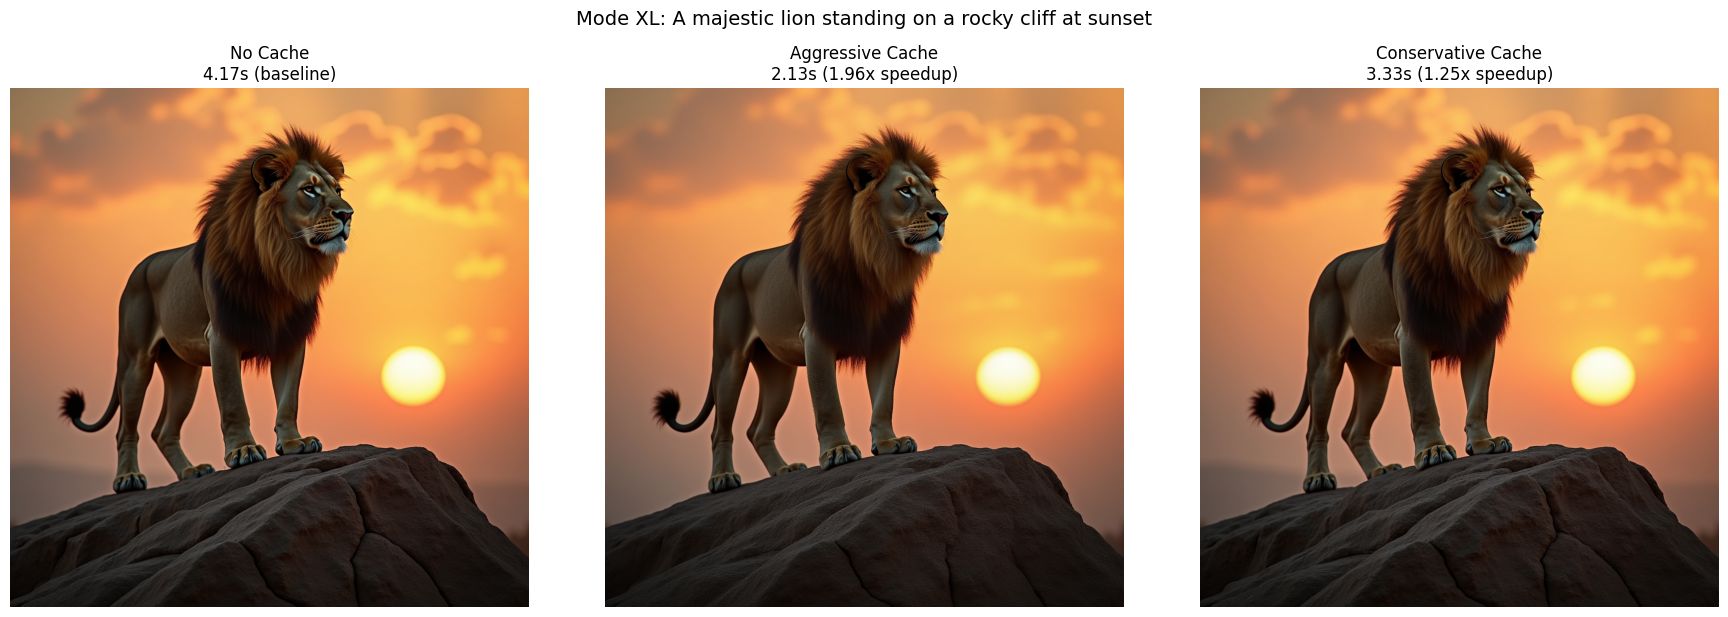

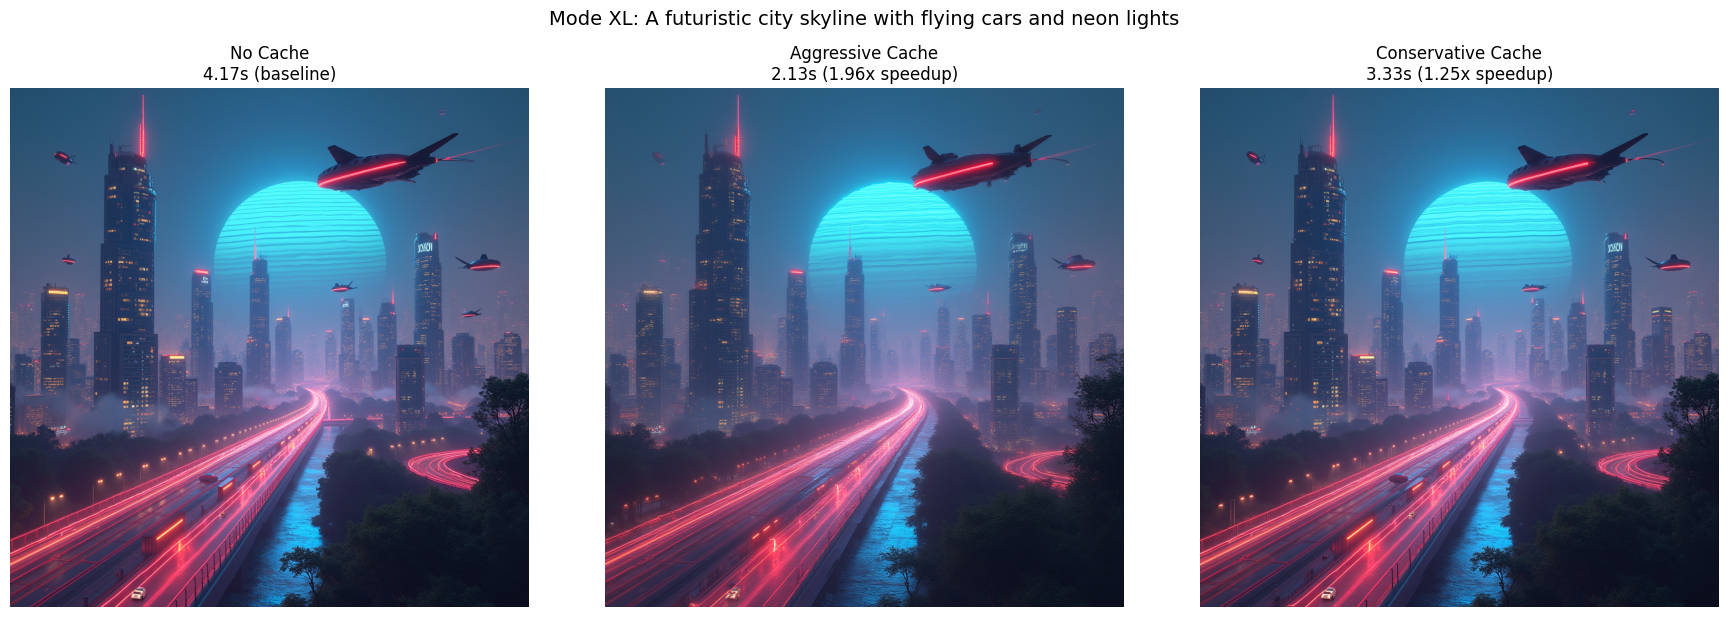

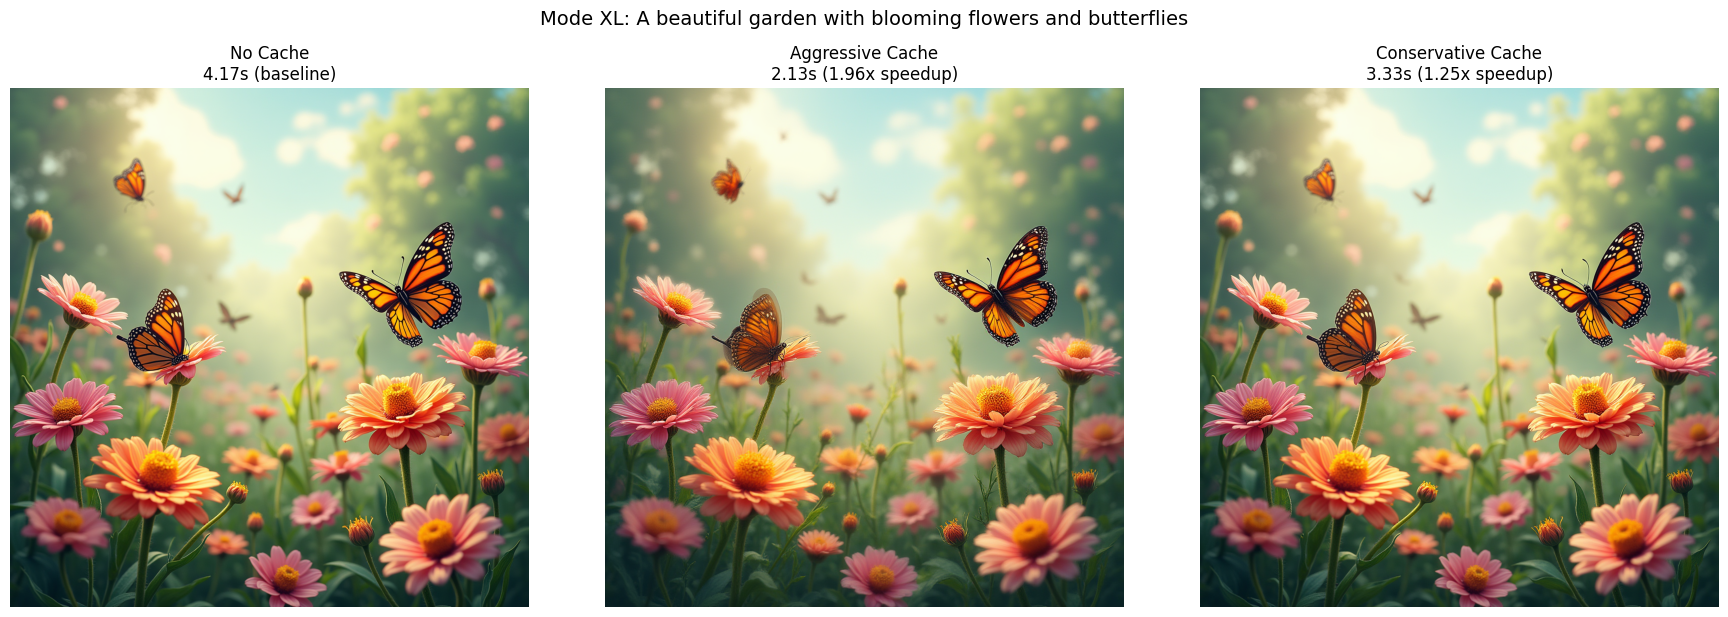

In [14]:
# Visualize XL results using utility function
print("\nXL Mode Comparison:")
for i in range(len(TEST_PROMPTS)):
    visualize_comparison(results_xl, 'XL', TEST_PROMPTS, OUTPUT_DIR, prompt_idx=i)


S Mode Comparison:


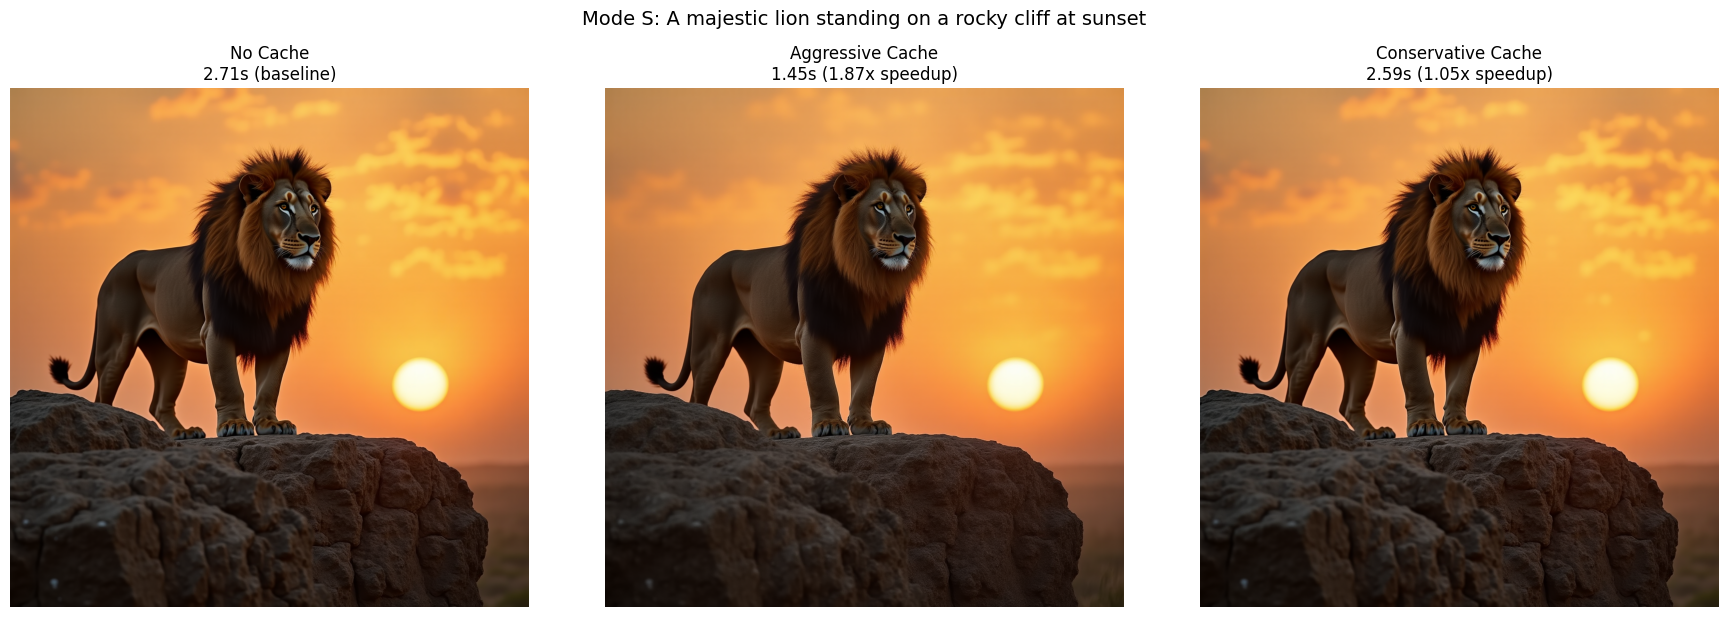

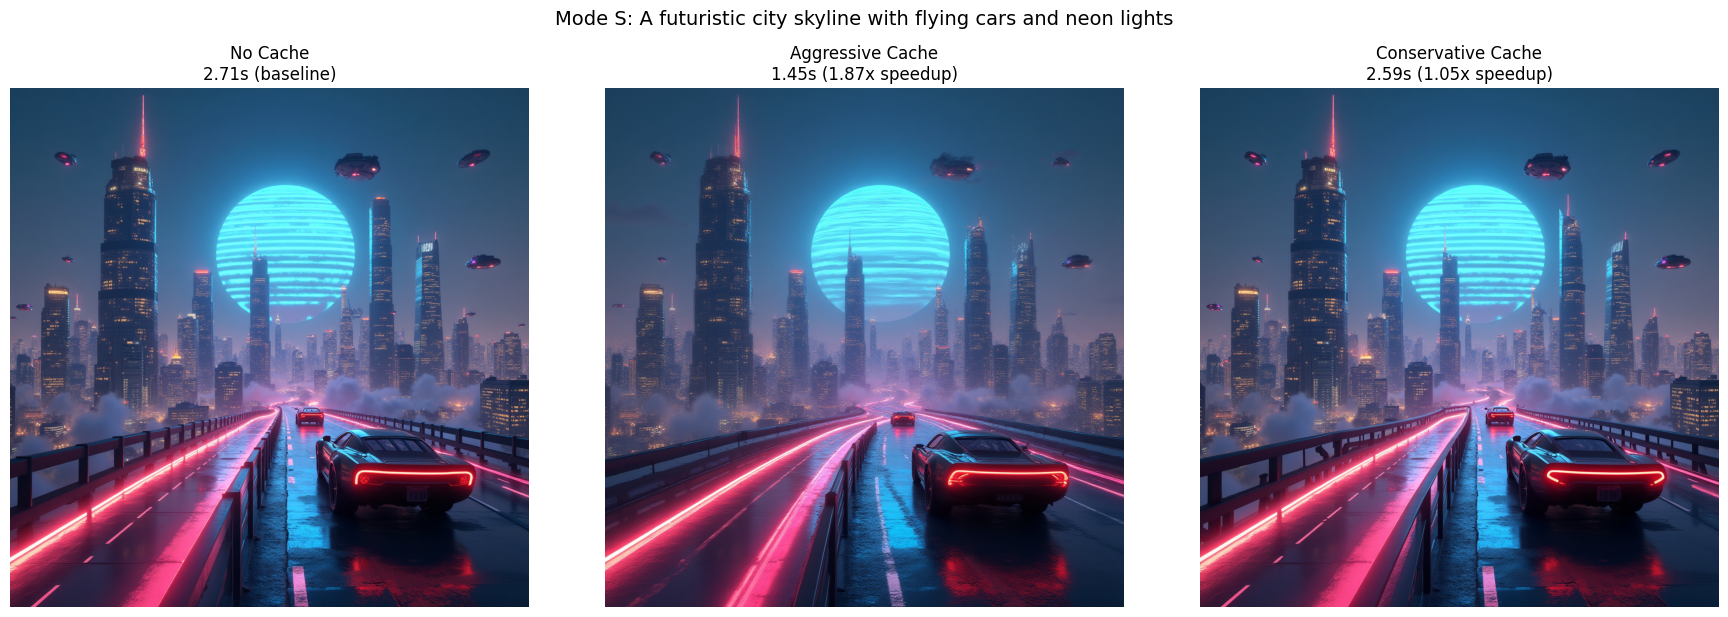

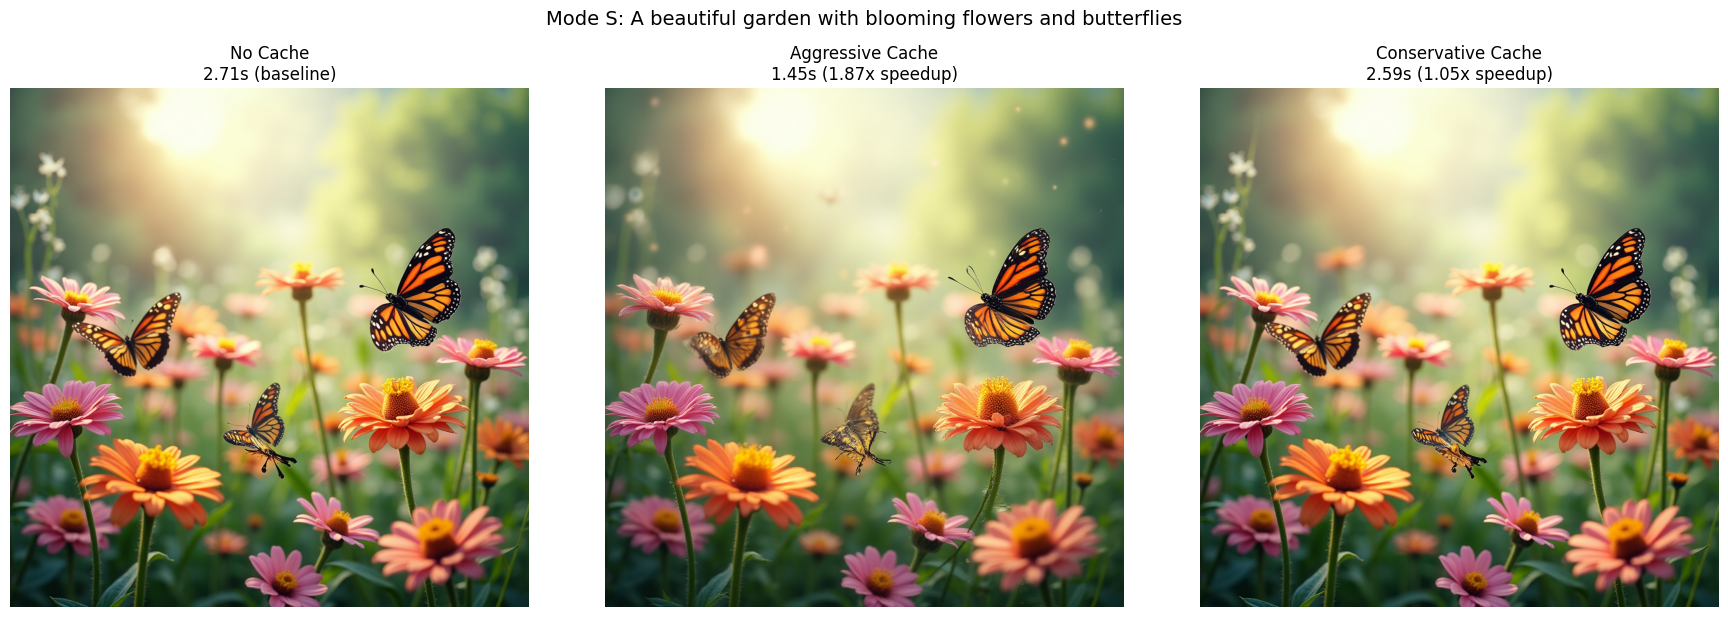

In [15]:
# Visualize S results using utility function
print("\nS Mode Comparison:")
for i in range(len(TEST_PROMPTS)):
    visualize_comparison(results_s, 'S', TEST_PROMPTS, OUTPUT_DIR, prompt_idx=i)

## 8. Performance Bar Charts

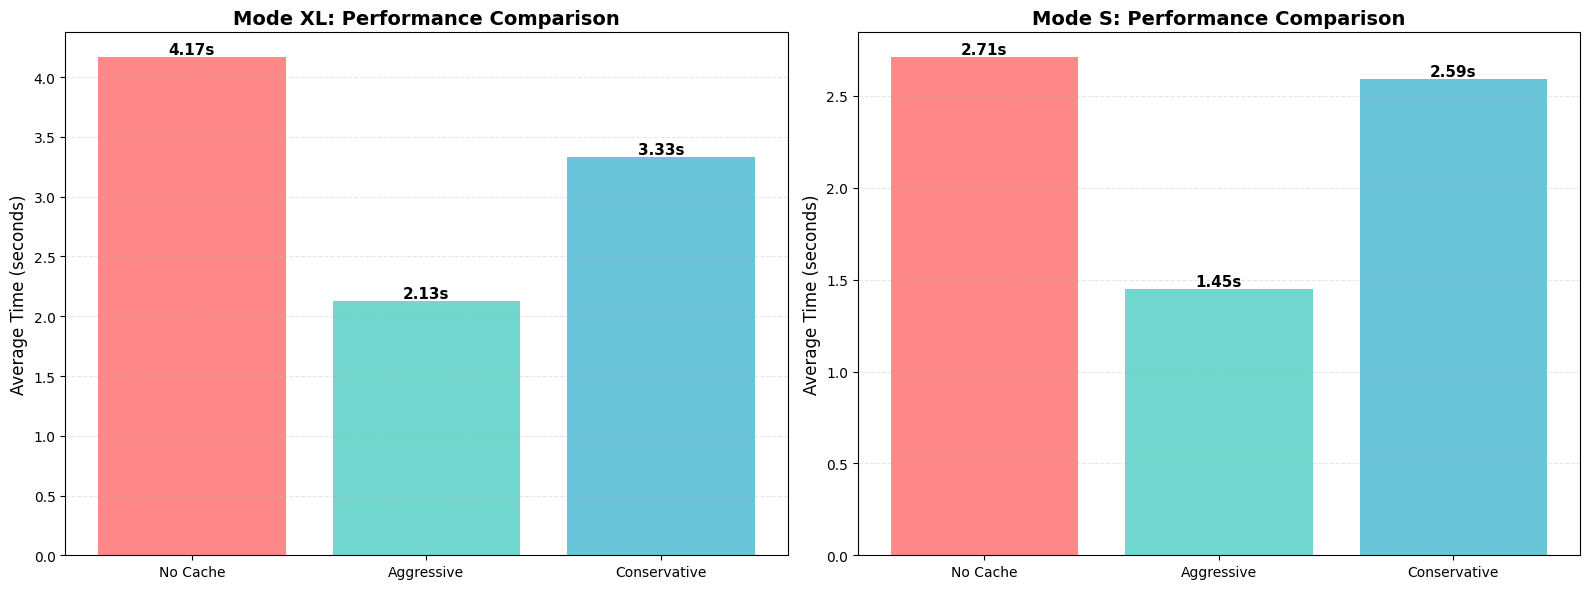

In [16]:
# Create performance comparison charts using utility function
create_performance_charts(results_xl, results_s, OUTPUT_DIR)

## 9. Conclusions

### Key Findings:

1. **Caching provides significant speedups**: Both aggressive and conservative caching strategies provide substantial performance improvements over no caching.

2. **Aggressive vs Conservative trade-off**:
   - **Aggressive**: Higher speedup, but may have slightly lower quality in very dynamic scenes
   - **Conservative**: Balanced speedup with better quality preservation

3. **Elastic modes + Caching = Maximum speedup**: Combining a smaller elastic model (S) with aggressive caching provides the best performance with acceptable quality trade-offs.

4. **Visual quality**: As seen in the comparisons above, the quality difference between caching strategies is often minimal for most prompts.

### Recommendations:

- **For production/quality-critical**: Use **XL + Conservative Cache**
- **For fast iteration/prototyping**: Use **S + Aggressive Cache**
- **For balanced performance**: Use **XL + Aggressive Cache** or **S + Conservative Cache**

### Next Steps:

1. Try with your own prompts and use cases
2. Experiment with custom cache configurations (Fn, Bn, rdt parameters)
3. Measure quality metrics on larger datasets
4. Combine with other optimizations (quantization, compilation)